In [9]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import tifffile as tiff
import pickle

import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

import torch_geometric.utils
import torch
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#p_dir = (Path().cwd().parents[0]).absolute()
p_dir = 'Y:\\coskun-lab\\Thomas\\11_snowflakes'

module_path = str(p_dir + "\\src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [12]:
#data_dir = (Path().cwd().parents[0] / 'data').absolute()
data_dir = (p_dir + '\\data')

In [13]:
import graph
import torch
import torch_geometric.utils
import networkx as nx
import lightning.pytorch as pl
import torch.utils.data as data

spatial_omics_folder = p_dir + '\\data' + '\\spatial_omics_graph'
process_path = p_dir + '\\data' + '\\torch_graph_data'

In [14]:
def visualize_graph(G, pos, color, ax, invert=True, **kwargs):
    nx.draw_networkx(G, pos=pos, with_labels=False, 
                     node_color=color, ax=ax, **kwargs)
    ax.axis('equal')
    if invert:
        ax.invert_yaxis()
        ax.set_facecolor('k')

def get_percentiles(array, percentiles= [10, 45, 55, 90]):
    # Get percentiles
    m = np.percentile(array, percentiles)
    low = np.where(array <= m[0])[0]
    high = np.where(array > m[-1])[0]
    mid = np.where((array>m[1]) & (array<=m[2]))[0]

    return low, high, mid

def get_node_subgraph(G, high_nodes, min_comp=4):
    nodes = np.array(list(G_new))

    G_high_nodes = G.subgraph(nodes[high_nodes]).copy()
    G_high_nodes.remove_nodes_from(list(nx.isolates(G_high_nodes)))
    for component in list(nx.connected_components(G_high_nodes)):
        if len(component)<min_comp:
            for node in component:
                G_high_nodes.remove_node(node)
    high_nodes = np.array(list(G_high_nodes))
    return G_high_nodes, high_nodes

def get_edge_subgraph(G, high_edges, min_comp=4):
    edges = list(G.edges)

    G_high_edges = G.edge_subgraph([edges[i] for i in high_edges]).copy()
    nx.set_edge_attributes(G_high_edges, 
                        values = dict(zip(list(G_high_edges.edges()), edge_importances[high_edges])), 
                            name = 'weight') # Set edge weight from edge importance
    for component in list(nx.connected_components(G_high_edges)):
        if len(component)<min_comp:
            for node in component:
                G_high_edges.remove_node(node)
    high_nodes_edges = sorted(np.array(list(G_high_edges)))
    return G_high_edges, high_nodes_edges

def get_percentiles_df_edges(array, cell_types, G, percentiles= [10, 45, 55, 90]):

    # Get high importance nodes subgraphs
    low_edges, high_edges, mid_edges = get_percentiles(array)

    # Get induced subgraph of high edges
    _, high_nodes_edges = get_edge_subgraph(G, high_edges)
    _, mid_nodes_edges = get_edge_subgraph(G, mid_edges)
    _, low_nodes_edges = get_edge_subgraph(G, low_edges)

    # Get cell types 
    df_low = count_df(cell_types, low_nodes_edges)
    df_mid = count_df(cell_types, mid_nodes_edges)
    df_high = count_df(cell_types, high_nodes_edges)

    df_all = pd.concat([df_low, df_mid, df_high])
    df_all = df_all.fillna(0)
    df_all = df_all.div(df_all.sum(1), axis=0)
    df_all['Condition'] = ['Low', 'Mid', 'High']
    return df_all   

## Read data Frame

In [21]:
import scanpy as sc
import anndata as ad 
# Import spatial omics library
#import athena as ath
from spatialOmics import SpatialOmics

import networkx as nx
import matplotlib 

# Save data
#save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'adata'
save_path = p_dir + '\\' + 'data' + '\\' + 'adata'

# adata_combined = ad.read_h5ad(save_path / 'all.h5ad')
adata_foll = ad.read_h5ad(save_path + '\\' + 'foll.h5ad')
name_map = {'0': 'Ki67+ B-cell', '4': 'Ki67+', '5': 'Ki67+ Macrophage', '6':'CD20+ Macrophage', '3':'Plasma Cell', '8':'Other', '11':'Macrophage', '1':'B-cell', '7':'FDC', '18':'Dendritic cell', '13':'Other'}

adata_foll.obs['name'] = (
    adata_foll.obs["merged"]
    .map(lambda x: name_map.get(x, x))
    .astype("category")
)

adata_foll.uns["name_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata_foll.obs['name']))]

# Extract node class and colors
var = 'name'

cluster_label_order = adata_foll.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_foll.uns[f"{var}_colors"]
labels = adata_foll.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

df_cell_info = adata_foll.obs.copy()


KeyError: 'dendrogram_name'

In [ ]:
# Load edge and node info
# Save info data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'metadata' / 'explaination.pkl'

# Open a file and use dump()
with open(save_path, 'rb') as file:
      
    # A new file will be created
    info = pickle.load(file)

In [9]:
# Load info data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'metadata' / 'subgraph.pkl'

# Open a file and use dump()
with open(save_path, 'rb') as file:
      
    # A new file will be created
    subgraphs = pickle.load(file)

# Get Dataset

In [10]:
import graph
import torch

from torch_geometric.loader import DataLoader
seed = torch.Generator().manual_seed(42)

name = 'NIH_pos'

# Crate dataset
dataset = graph.GraphDatasetPos(process_path / name, process_path / name / 'info.csv', 2, y_name='covid')

train_set, val_set, test_set = graph.train_test_val_split(dataset)

# Create Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [11]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.nc}')

Dataset: GraphDatasetPos(442):
Number of graphs: 442
Number of features: 6
Number of classes: 2


In [12]:
print(f'Train set: {len(train_set)}, val set: {len(test_set)}, val set: {len(val_set)}')

Train set: 213, val set: 176, val set: 53


# Comparison of marker expression value 

In [63]:
# Covid mapping from patient id to covid. Covid = 1, Normal = 0
covid_dict = {'3': 'Negative', '5': 'Positive', '6': 'Negative', '8':'Positive',
             '11': 'Positive', '18': 'Negative', '21':'Negative', '22': 'Positive'}


dfs = []

# Plot example of spatial projection
for d in adata_foll.obs.Dataset.unique():
    adata_donor = adata_foll[adata_foll.obs.Dataset == d, :]
    
    # Get Covid status
    covid_status = covid_dict[d[1:]]
    
    # Count cell type per follicles
    df = pd.DataFrame(adata_donor.X, columns = adata_donor.var_names.tolist())
    df['Condition'] = covid_status
    
    dfs.append(df)

In [65]:
# Concatenate 
df = pd.concat(dfs)
df = df.reset_index(drop=True)

# Melt dataframe
df_all = df.melt(id_vars='Condition', value_name='Expression', var_name='Marker')
df_all

,Condition,Marker,Expression
0,Positive,CD21,0.625137
1,Positive,CD21,0.682259
2,Positive,CD21,-0.167621
3,Positive,CD21,1.301578
4,Positive,CD21,1.025034
...,...,...,...
7886325,Positive,CD138,-0.370700
7886326,Positive,CD138,-0.325563
7886327,Positive,CD138,-0.336178
7886328,Positive,CD138,-0.323776


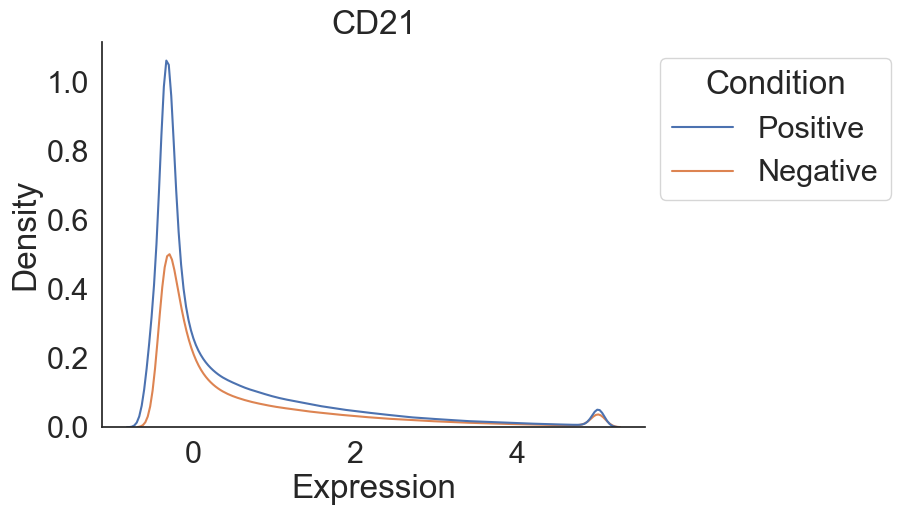

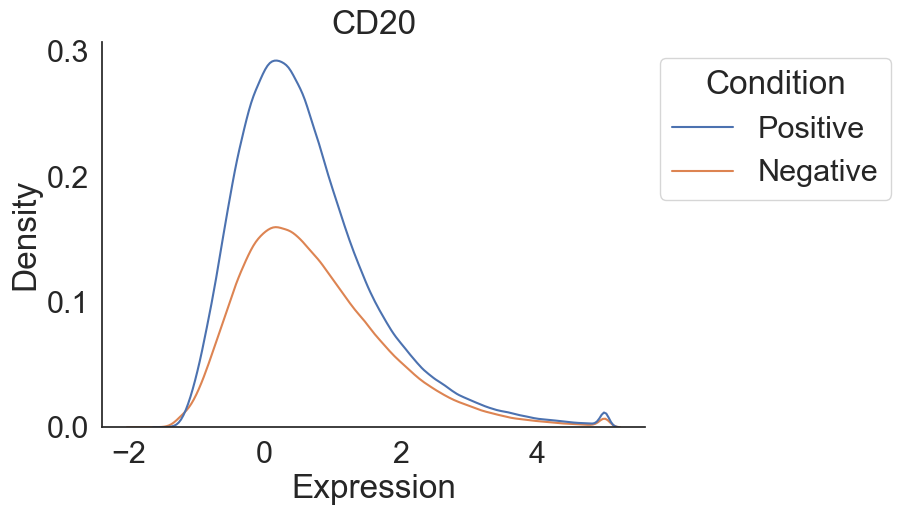

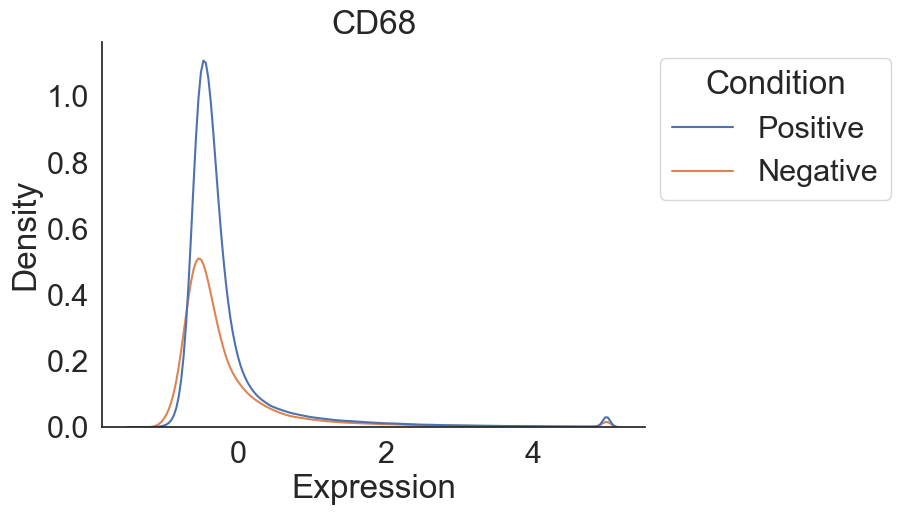

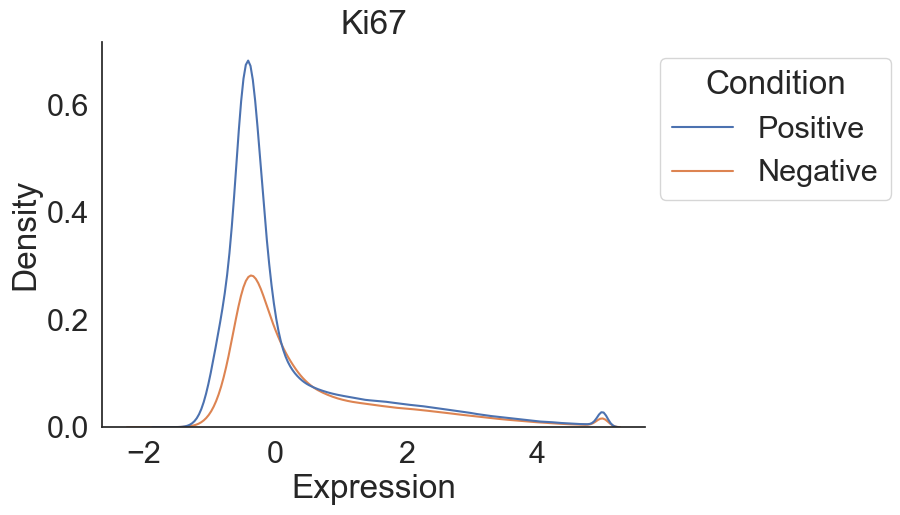

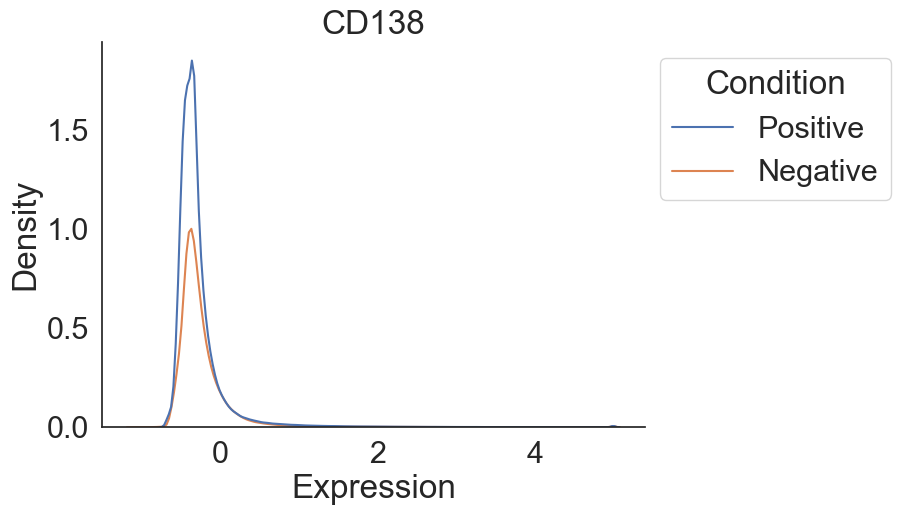

In [80]:
for marker in df_all.Marker.unique():
    fig, ax = plt.subplots(figsize=(7,5))
    sns.kdeplot(data=df_all[df_all.Marker == marker], x='Expression', hue='Condition',ax=ax)
    sns.despine()
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(marker)
    plt.show()


In [66]:
from statannotations.stats.StatTest import StatTest

from scipy.stats import ttest_ind

# Any function that follows the StatTest API could go here
def ttest(group_data1, group_data2, **stats_params):

    return ttest_ind(group_data1, group_data2, equal_var=False,  alternative='two-sided',**stats_params)

# Required descriptors for annotate
custom_long_name = ' two-sided two-sample t-test'
custom_short_name = 'two-t'
custom_func = ttest
custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD20_Positive vs. CD20_Negative:  two-sided two-sample t-test, P_val:1.021e-02 Stat=-2.573e+00
CD21_Positive vs. CD21_Negative:  two-sided two-sample t-test, P_val:4.105e-02 Stat=-2.045e+00
CD68_Positive vs. CD68_Negative:  two-sided two-sample t-test, P_val:8.047e-01 Stat=2.473e-01
Ki67_Positive vs. Ki67_Negative:  two-sided two-sample t-test, P_val:4.938e-05 Stat=-4.074e+00
CD138_Positive vs. CD138_Negative:  two-sided two-sample t-test, P_val:1.467e-02 Stat=-2.444e+00


(<Axes: xlabel='Marker', ylabel='Expression'>,
  <statannotations.Annotation.Annotation at 0x20cb5f27210>])

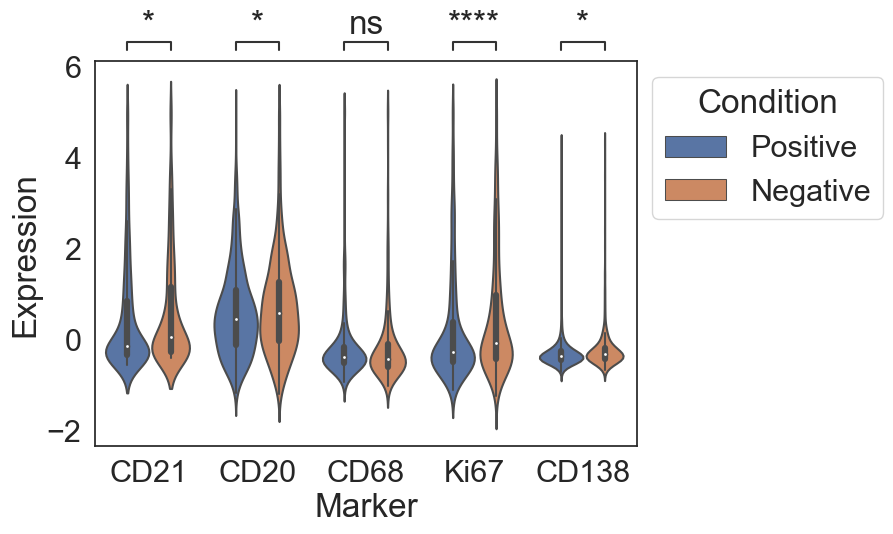

In [68]:
sns.set(font_scale=2)
sns.set_style("white")

pairs=[((c, 'Positive'), (c, 'Negative')) for c in df_all.Marker.unique()]

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(data=df_all.iloc[::1000], x='Marker', y='Expression', hue='Condition', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

annotator = Annotator(ax, data=df_all.iloc[::1000], x='Marker', y='Expression', hue='Condition', pairs=pairs)
annotator.configure(test=custom_test, text_format='star', loc='outside', )
annotator.apply_and_annotate()


# Get cell intensity distribution comparing high attention cell vs all cells

In [81]:
import joypy

In [82]:
adata_foll

AnnData object with n_obs × n_vars = 1577266 × 5
    obs: 'ROI', 'Cell', 'Cell_ROI', 'Dataset', 'Data', 'Foll', 'GC', 'leiden', 'merged', 'name'
    uns: 'Dataset_colors', 'dendrogram_leiden', 'dendrogram_merged', 'dendrogram_name', 'leiden', 'merged_colors', 'name_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [83]:
# df = pd.DataFrame(adata_foll.X, columns = adata_foll.var_names.tolist())
# fig, axes = joypy.joyplot(df)

In [84]:
# Transform subgraphs into scanpy
adatas_high = []
adatas_low = []
for k, v in subgraphs.items():
    if 'mid' in k:
        continue 
    if 'low' in k:
        continue 
    
    if v['label'] == 1:
        adata_subset = adata_foll[(adata_foll.obs.Dataset == k.split('_')[0]) & (adata_foll.obs.Foll == int(k.split('_')[1]))]
        adata_high = adata_subset[np.concatenate(v['components'])]  

        adatas_high.append(adata_high)

    if v['label'] == 0:
        adata_subset = adata_foll[(adata_foll.obs.Dataset == k.split('_')[0]) & (adata_foll.obs.Foll == int(k.split('_')[1]))]
        adata_low = adata_subset[np.concatenate(v['components'])]  

        adatas_low.append(adata_low)

In [85]:
adata_high_all = ad.concat(adatas_high)
df_high = pd.DataFrame(adata_high_all.X, columns = adata_high_all.var_names.tolist())

adata_low_all = ad.concat(adatas_low)
df_low = pd.DataFrame(adata_low_all.X, columns = adata_low_all.var_names.tolist())

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [86]:
adata_high_all 

AnnData object with n_obs × n_vars = 183883 × 5
    obs: 'ROI', 'Cell', 'Cell_ROI', 'Dataset', 'Data', 'Foll', 'GC', 'leiden', 'merged', 'name'
    obsm: 'X_umap', 'spatial'

In [87]:
adata_low_all

AnnData object with n_obs × n_vars = 110327 × 5
    obs: 'ROI', 'Cell', 'Cell_ROI', 'Dataset', 'Data', 'Foll', 'GC', 'leiden', 'merged', 'name'
    obsm: 'X_umap', 'spatial'

In [88]:
df_high_melt = df_high.melt(var_name='Marker', value_name='Expression')
df_high_melt['Condition'] = 'Positive'
df_low_melt = df_low.melt(var_name='Marker', value_name='Expression')
df_low_melt['Condition'] = 'Negative'

df_all = pd.concat([df_high_melt, df_low_melt])

In [89]:
from statannotations.Annotator import Annotator


In [90]:
df_all

,Marker,Expression,Condition
0,CD21,2.922516,Positive
1,CD21,2.033059,Positive
2,CD21,4.481879,Positive
3,CD21,2.662502,Positive
4,CD21,5.000000,Positive
...,...,...,...
551630,CD138,-0.113400,Negative
551631,CD138,-0.322885,Negative
551632,CD138,-0.192774,Negative
551633,CD138,-0.309188,Negative


In [91]:
from statannotations.stats.StatTest import StatTest

from scipy.stats import ttest_ind

# Any function that follows the StatTest API could go here
def ttest(group_data1, group_data2, **stats_params):

    return ttest_ind(group_data1, group_data2, equal_var=False,  alternative='two-sided',**stats_params)

# Required descriptors for annotate
custom_long_name = ' two-sided two-sample t-test'
custom_short_name = 'two-t'
custom_func = ttest
custom_test = StatTest(custom_func, custom_long_name, custom_short_name)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

CD20_Positive vs. CD20_Negative:  two-sided two-sample t-test, P_val:1.721e-01 Stat=-1.366e+00
CD21_Positive vs. CD21_Negative:  two-sided two-sample t-test, P_val:1.166e-07 Stat=-5.317e+00
CD68_Positive vs. CD68_Negative:  two-sided two-sample t-test, P_val:1.153e-01 Stat=-1.575e+00
Ki67_Positive vs. Ki67_Negative:  two-sided two-sample t-test, P_val:1.013e-18 Stat=-8.914e+00
CD138_Positive vs. CD138_Negative:  two-sided two-sample t-test, P_val:1.619e-04 Stat=-3.779e+00


(<Axes: xlabel='Marker', ylabel='Expression'>,
  <statannotations.Annotation.Annotation at 0x20cbb3b8110>])

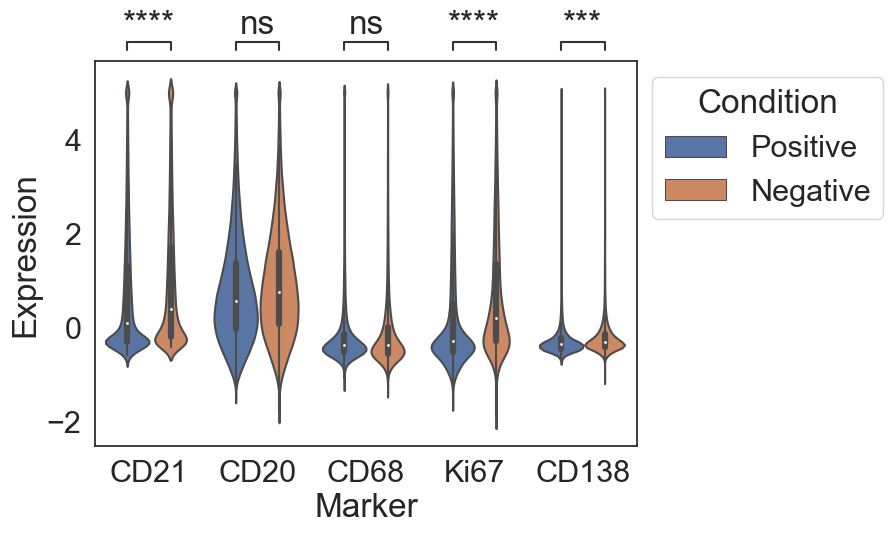

In [92]:
sns.set(font_scale=2)
sns.set_style("white")

pairs=[((c, 'Positive'), (c, 'Negative')) for c in df_all.Marker.unique()]

fig, ax = plt.subplots(figsize=(7,5))
sns.violinplot(data=df_all, x='Marker', y='Expression', hue='Condition', ax=ax)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

annotator = Annotator(ax, data=df_all.iloc[::100], x='Marker', y='Expression', hue='Condition', pairs=pairs)
annotator.configure(test=custom_test, text_format='star', loc='outside', )
annotator.apply_and_annotate()


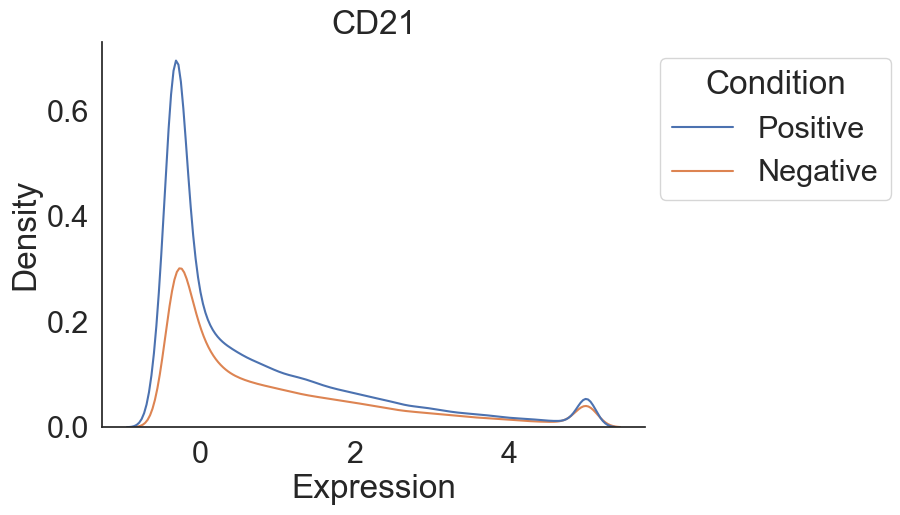

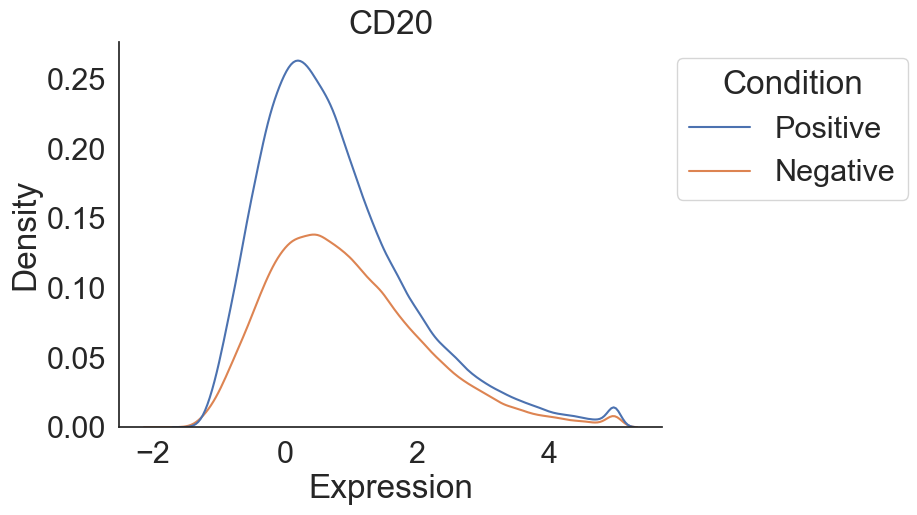

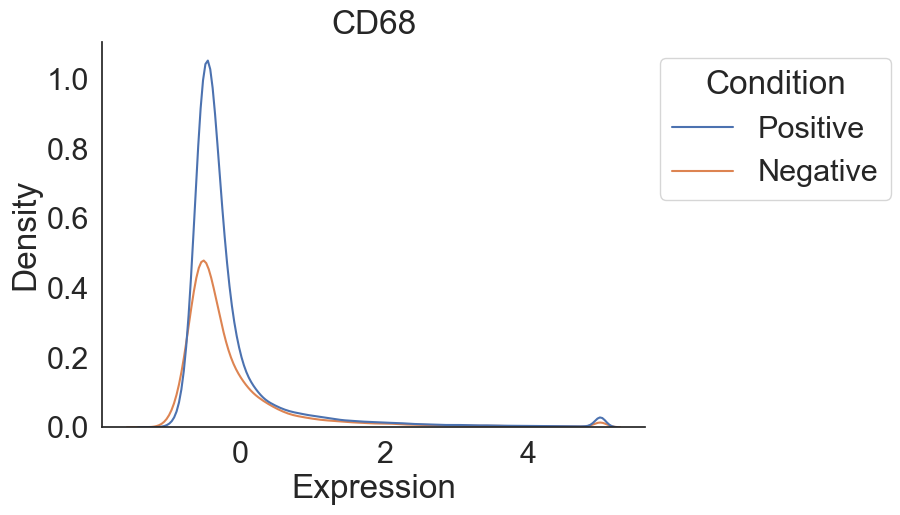

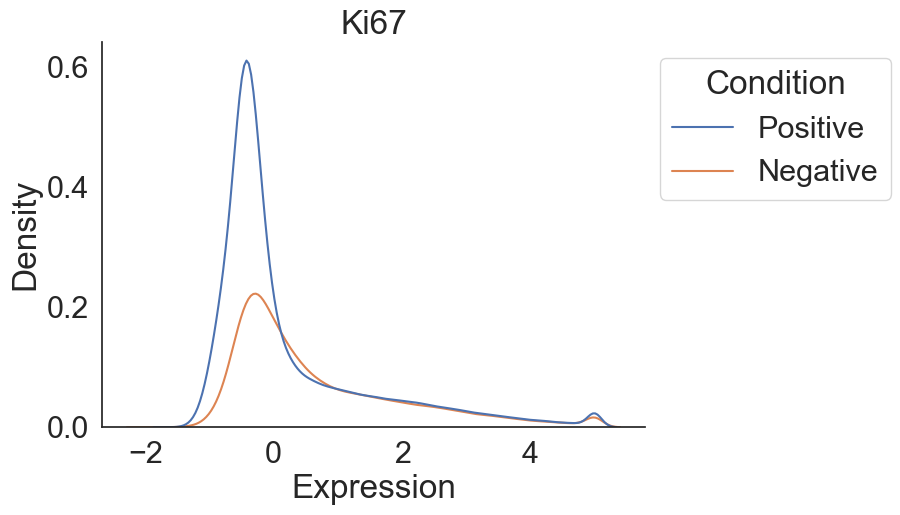

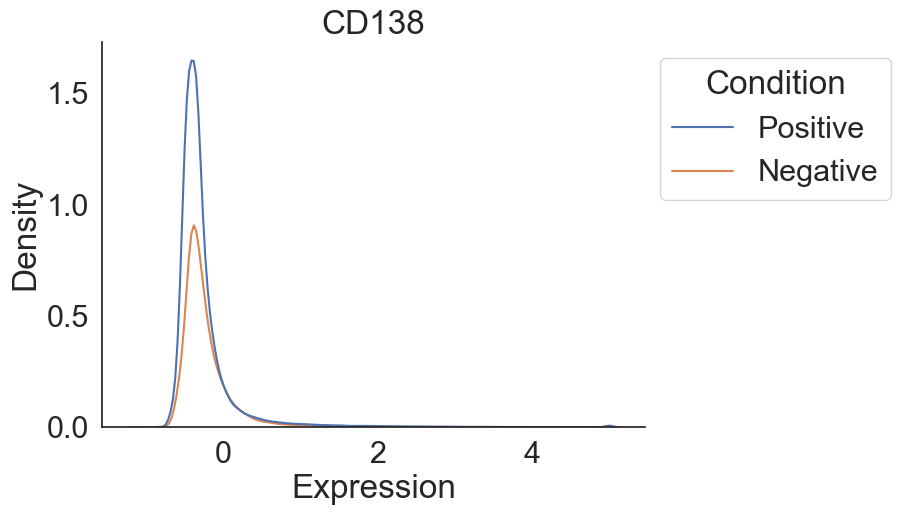

In [93]:
for marker in df_all.Marker.unique():
    fig, ax = plt.subplots(figsize=(7,5))
    sns.kdeplot(data=df_all[df_all.Marker == marker], x='Expression', hue='Condition',ax=ax)
    sns.despine()
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(marker)
    plt.show()


## Comparison high vs negative attribution